In [1]:
import mdsine2 as md2
from mdsine2.names import STRNAMES
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import os
import pandas as pd
from pathlib import Path
import matplotlib.cm as cm
import seaborn as sns

md2.visualization.set_perturbation_color('gray')
cols = [cm.tab10(i) for i in range(10)]
cols.append(cm.Set2(5))
cols.append(cm.Paired(4))

[DEBUG] Using default logger (stdout, stderr).


In [2]:
# Input directories
dir_lf0 = Path('mcnulty-results/LF0')
dir_hf0 = Path('mcnulty-results/HF0')

# Output directories
output_dir_lf0 = dir_lf0 / "r-hat"
output_dir_hf0 = dir_hf0 / "r-hat"
output_dir_lf0.mkdir(exist_ok=True, parents=True)
output_dir_hf0.mkdir(exist_ok=True, parents=True)

In [3]:
# Load the chains for each dataset
seeds = [0, 4, 27]
chains_lf0 = [pd.read_pickle(f'{dir_lf0}/mdsine2/seed{seed}/mcmc.pkl') for seed in seeds]
chains_hf0 = [pd.read_pickle(f'{dir_hf0}/mdsine2/seed{seed}/mcmc.pkl') for seed in seeds]

In [4]:
# Calculate the shrink factor for a set of chains for a given variable through a series of windows
def shrink_factor(chains, vname, window=1000, save=False):
    r_hat_window = []
    j = 0
    while j < chains[0].n_samples:
        r_hat_window.append(md2.pylab.inference.r_hat(chains, start=j, end=j+window, vname=vname))
        j += window
    if save:
        dataset = chains[0].graph.name.split('_')[0]
        if dataset == 'LF0':
            np.save(f'{output_dir_lf0}/{vname}_rhat.npy', r_hat_window)
        elif dataset == 'HF0':
            np.save(f'{output_dir_hf0}/{vname}_rhat.npy', r_hat_window)
    return np.array(r_hat_window)

# Plot the shrink factor for a set of chains for a given variable through a series of windows
def plot_shrink_factor(chains, vname=STRNAMES.GROWTH_VALUE, window=1000, layout='overlaped', save=False):
    dataset = chains[0].graph.name.split('_')[0]
    shrink_factors = shrink_factor(chains, vname, window)
    taxa = [chains[0].graph.data.taxa[i].name for i in range(len(chains[0].graph.data.taxa))]
    shape_len = len(shrink_factors.shape)
    shape = shape = shrink_factors.shape[1]
    if shape_len <= 2:
        if layout == 'overlaped':
            fig = plt.figure(figsize=(12, 8))
            for i in range(shrink_factors.shape[1]):
                species = f'{taxa[i].split("_")[0]}. {taxa[i].split("_")[1]}'
                plt.plot(shrink_factors[:,i], alpha=0.8, color=cols[i], label=species)
            plt.xlabel('Window')
            plt.ylabel('Rhat')
            plt.title(f'{dataset} Rhat {chains[0].graph[vname].name}')
            plt.legend()
            plt.grid()
            if save:
                if dataset == 'LF0':
                    plt.savefig(f'{output_dir_lf0}/{vname}_rhat_{layout}.png', dpi=300)
                elif dataset == 'HF0':
                    plt.savefig(f'{output_dir_hf0}/{vname}_rhat_{layout}.png', dpi=300)
                else:
                    raise ValueError('Dataset must be LF0 or HF0')
            return fig
        elif layout == 'mean':
            fig = plt.figure(figsize=(12, 8))
            plt.plot(np.mean(shrink_factors, axis=1))
            plt.xlabel('Window')
            plt.ylabel('Rhat')
            plt.title(f'{dataset} Rhat {chains[0].graph[vname].name}')
            plt.grid()
            if save:
                if dataset == 'LF0':
                    plt.savefig(f'{output_dir_lf0}/{vname}_rhat_{layout}.png', dpi=300)
                elif dataset == 'HF0':
                    plt.savefig(f'{output_dir_hf0}/{vname}_rhat_{layout}.png', dpi=300)
                else:
                    raise ValueError('Dataset must be LF0 or HF0')
            return fig
        elif layout == 'subplots':
            fig, ax = plt.subplots(4,3, figsize=(12, 16), sharex=True, sharey=True)
            row=0
            col=0
            for i in range(shape):
                species = f'{taxa[i].split("_")[0]}. {taxa[i].split("_")[1]}'
                ax[row,col].plot(shrink_factors[:, i])
                ax[row,col].set_title(f'${species}$')
                ax[row,col].grid()
                col += 1
                if col == 3:
                    col = 0
                    row += 1
            fig.supxlabel('Window', y=0.08)
            fig.supylabel('Rhat', x=0.08)
            fig.suptitle(f'{dataset} Rhat {chains[0].graph[vname].name}', y=0.92)
            if save:
                if dataset == 'LF0':
                    plt.savefig(f'{output_dir_lf0}/{vname}_rhat_{layout}.png', dpi=300)
                elif dataset == 'HF0':
                    plt.savefig(f'{output_dir_hf0}/{vname}_rhat_{layout}.png', dpi=300)
                else:
                    raise ValueError('Dataset must be LF0 or HF0')
            return fig
        else:
            raise ValueError('Layaout must be overlaped, subplots or mean')
    else:
        if layout == 'overlaped':
            fig = plt.figure(figsize=(12, 8))
            for i in range(shape):
                species = f'{taxa[i].split("_")[0]}. {taxa[i].split("_")[1]}'
                for j in range(shape):
                    if j == 0:
                        plt.plot(shrink_factors[:,i,j], alpha=0.8, color=cols[i], label=species)
                    else:
                        plt.plot(shrink_factors[:,i,j], alpha=0.8, color=cols[i])
            plt.xlabel('Window')
            plt.ylabel('Rhat')
            plt.title(f'{dataset} Rhat {chains[0].graph[vname].name}')
            plt.legend()
            plt.grid()
            if save:
                if dataset == 'LF0':
                    plt.savefig(f'{output_dir_lf0}/{vname}_rhat_{layout}.png', dpi=300)
                elif dataset == 'HF0':
                    plt.savefig(f'{output_dir_hf0}/{vname}_rhat_{layout}.png', dpi=300)
                else:
                    raise ValueError('Dataset must be LF0 or HF0')
            return fig
        elif layout == 'mean':
            fig = plt.figure(figsize=(12, 8))
            for i in range(shape):
                species = f'{taxa[i].split("_")[0]}. {taxa[i].split("_")[1]}'
                plt.plot(np.nanmean(shrink_factors, axis=1)[:,i], alpha=0.8, color=cols[i], label=species)
            plt.legend()
            plt.xlabel('Window')
            plt.ylabel('Rhat')
            plt.title(f'{dataset} Rhat {chains[0].graph[vname].name}')
            plt.grid()
            if save:
                if dataset == 'LF0':
                    plt.savefig(f'{output_dir_lf0}/{vname}_rhat_{layout}.png', dpi=300)
                elif dataset == 'HF0':
                    plt.savefig(f'{output_dir_hf0}/{vname}_rhat_{layout}.png', dpi=300)
                else:
                    raise ValueError('Dataset must be LF0 or HF0')
            return fig
        elif layout == 'subplots':
            fig, ax = plt.subplots(4,3, figsize=(12, 16), sharex=True, sharey=True)
            row=0
            col=0
            for i in range(shape):
                species_tit = f'{taxa[i].split("_")[0]}. {taxa[i].split("_")[1]}'
                for j in range(shape):
                    species = f'{taxa[j].split("_")[0]}. {taxa[j].split("_")[1]}'
                    ax[row,col].plot(shrink_factors[:, i, j], color=cols[j], alpha=0.8, label=species)
                ax[row,col].set_title(f'${species_tit}$')
                ax[row,col].grid()
                col += 1
                if col == 3:
                    col = 0
                    row += 1
            handles, labels = ax[0,0].get_legend_handles_labels()
            fig.legend(handles, labels, loc='lower center', ncol=4)
            fig.supxlabel('Window', y=0.08)
            fig.supylabel('Rhat', x=0.08)
            fig.suptitle(f'{dataset} Rhat {chains[0].graph[vname].name}', y=0.92)
            if save:
                if dataset == 'LF0':
                    plt.savefig(f'{output_dir_lf0}/{vname}_rhat_{layout}.png', dpi=300)
                elif dataset == 'HF0':
                    plt.savefig(f'{output_dir_hf0}/{vname}_rhat_{layout}.png', dpi=300)
                else:
                    raise ValueError('Dataset must be LF0 or HF0')
            return fig
        else:
            raise ValueError('Layaout must be overlaped, subplots or mean')

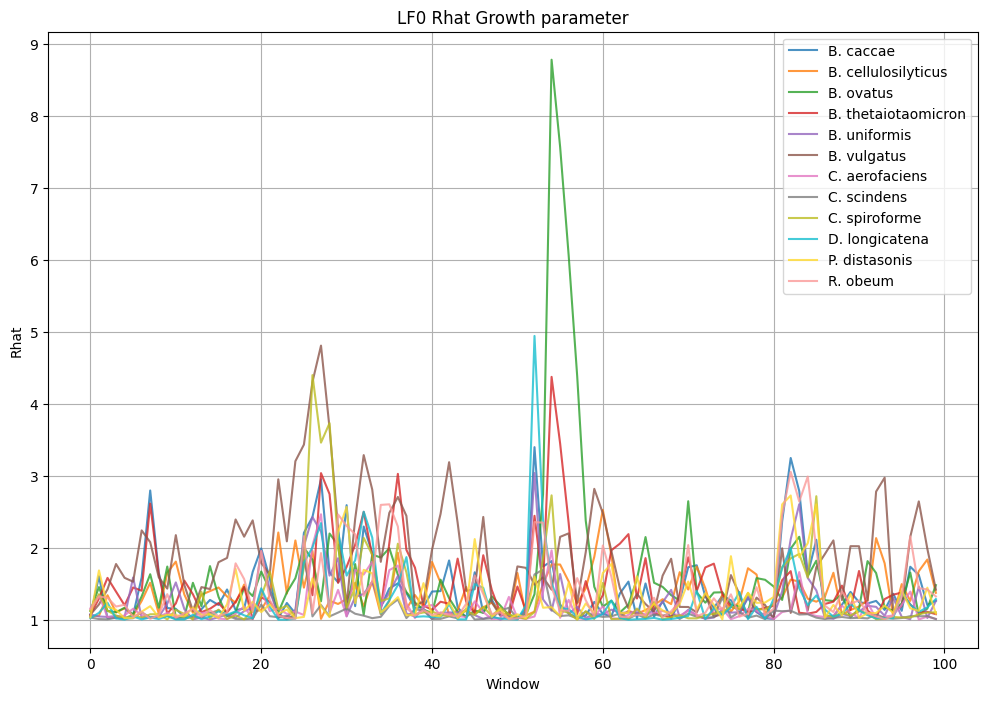

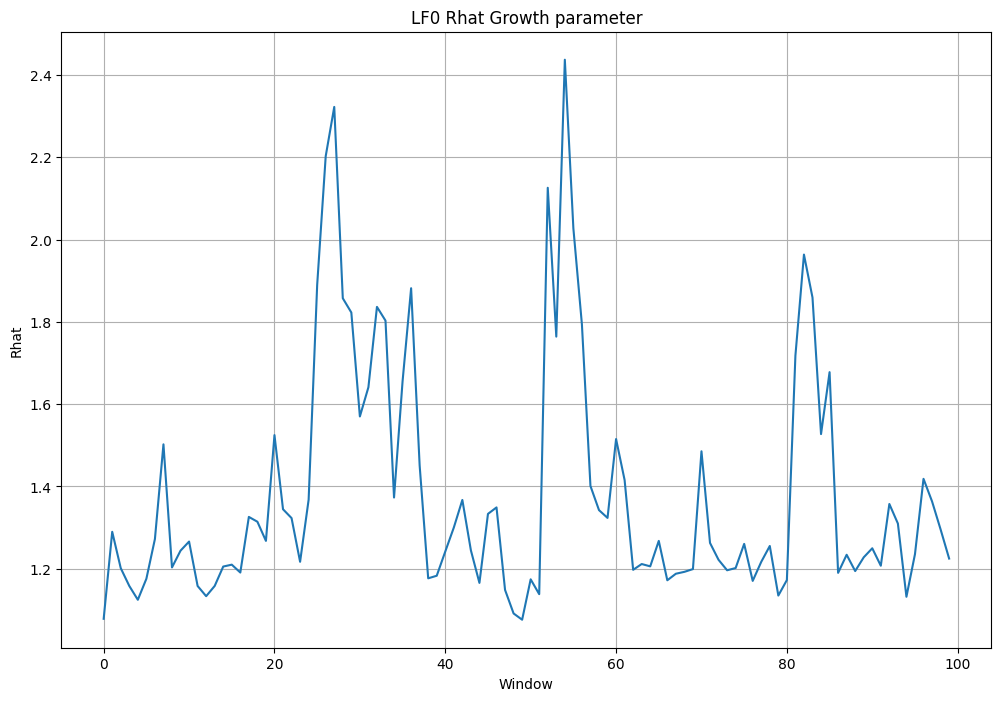

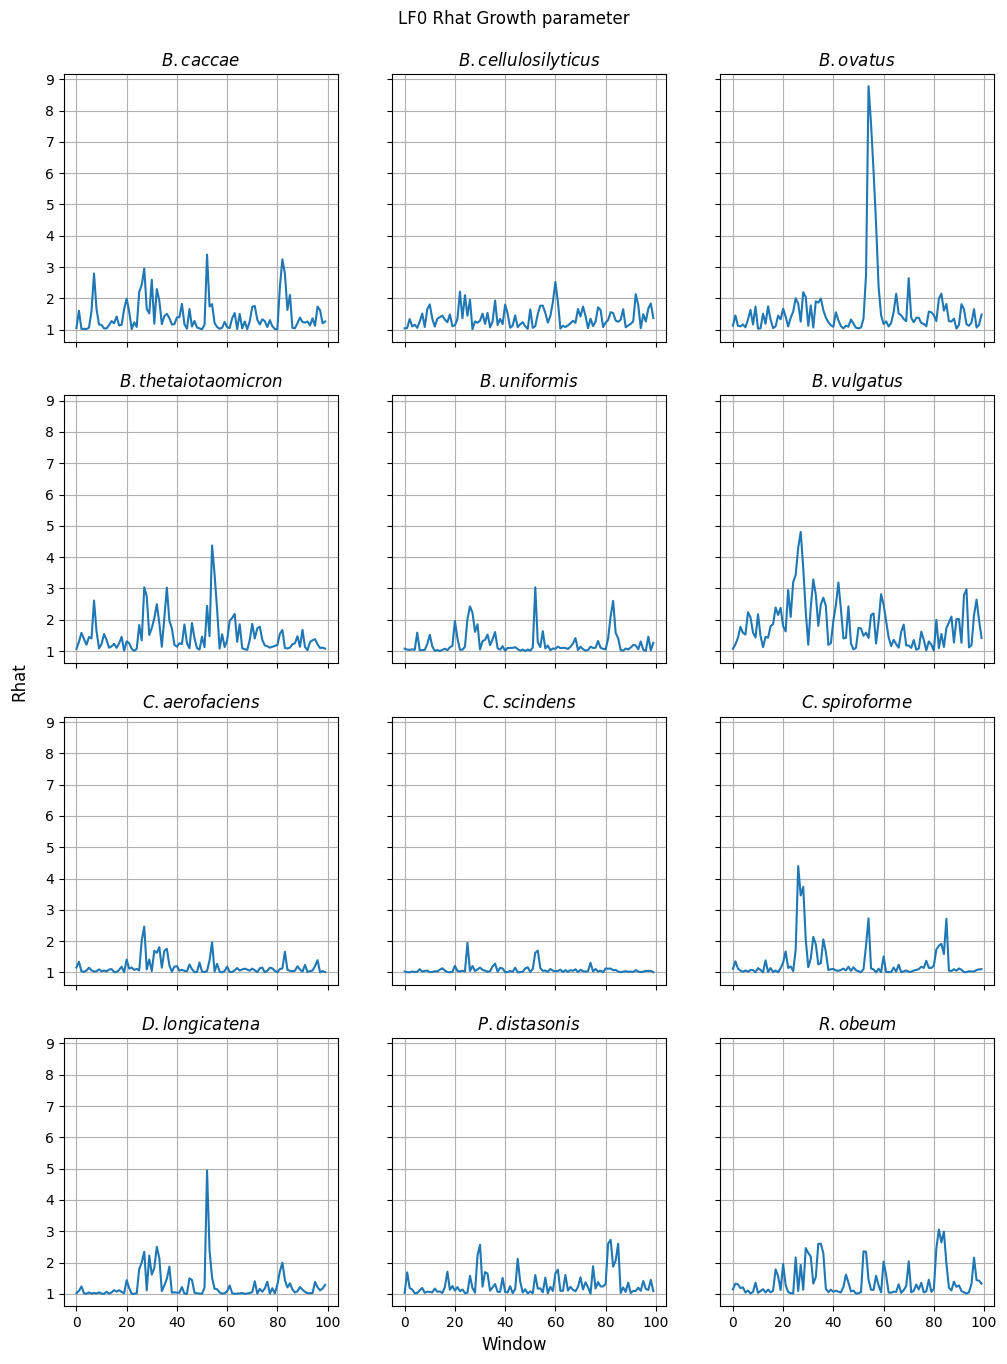

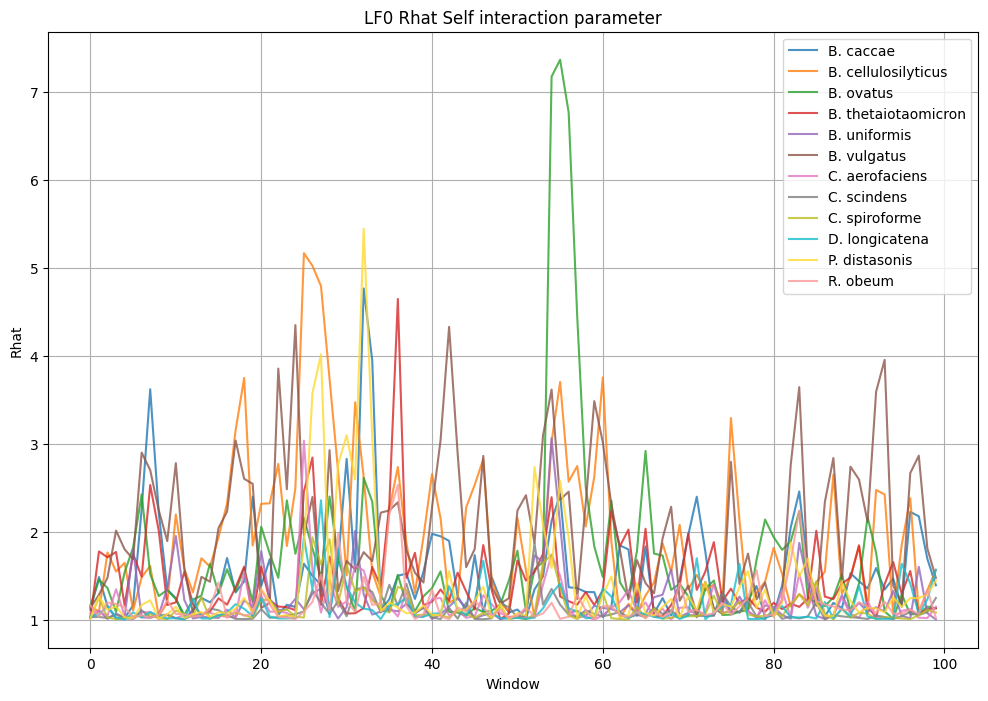

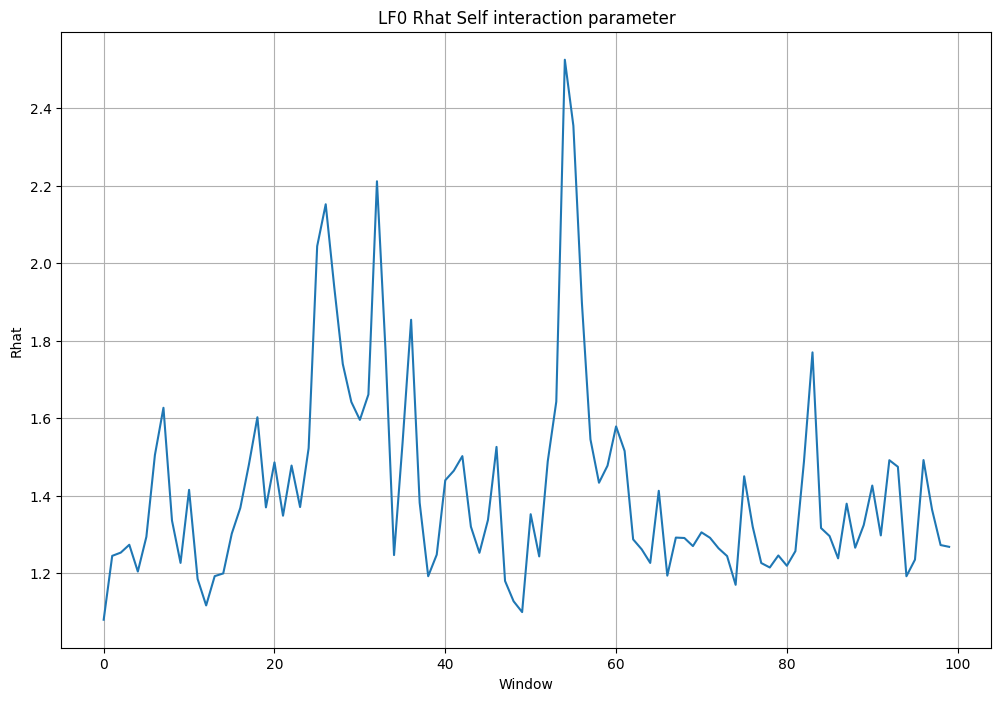

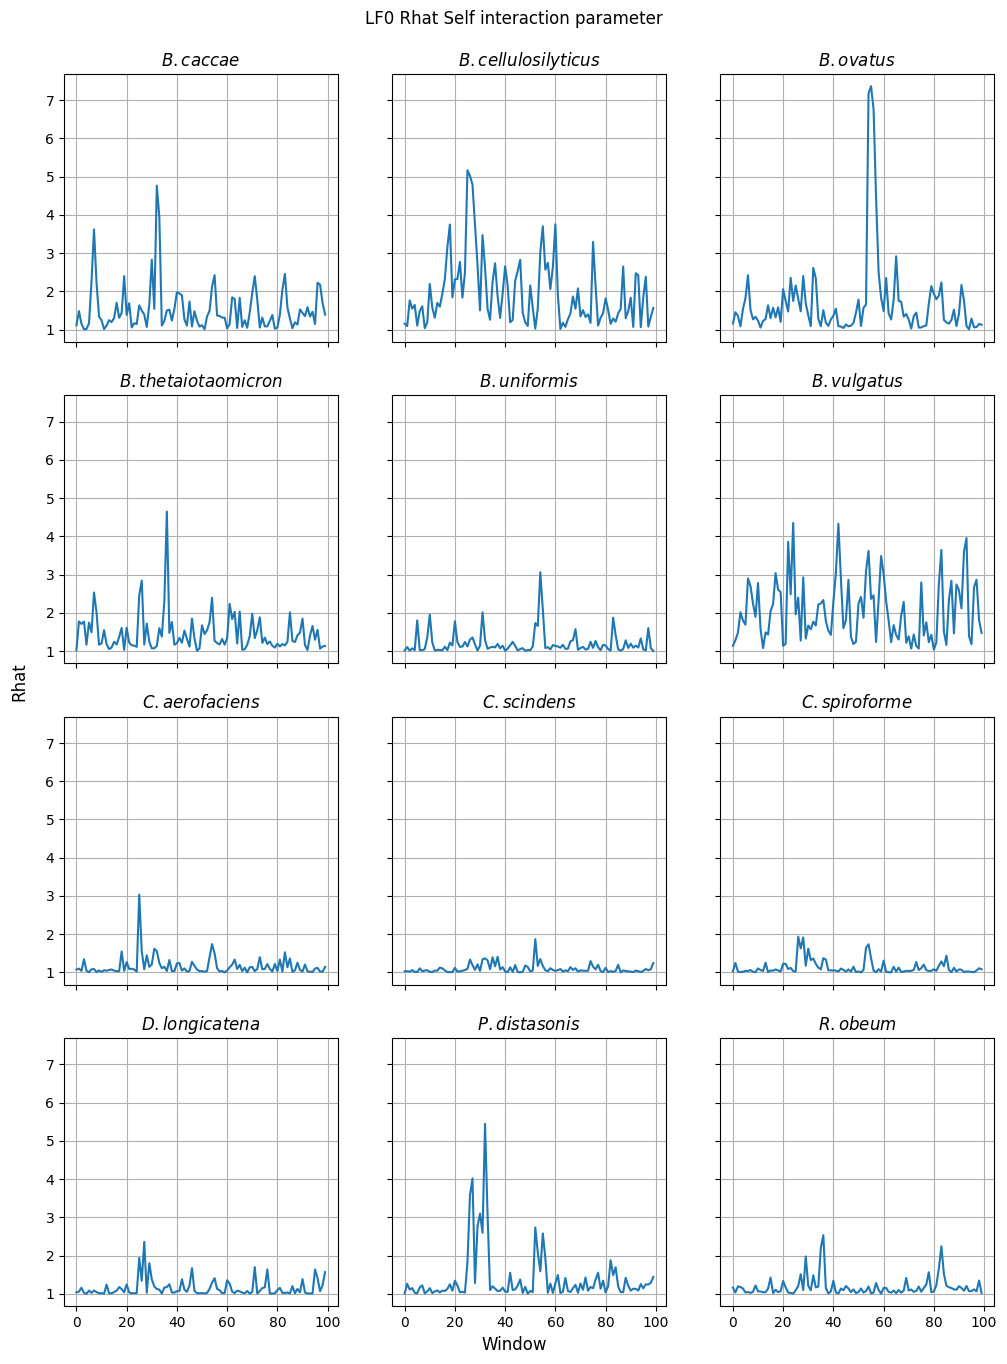

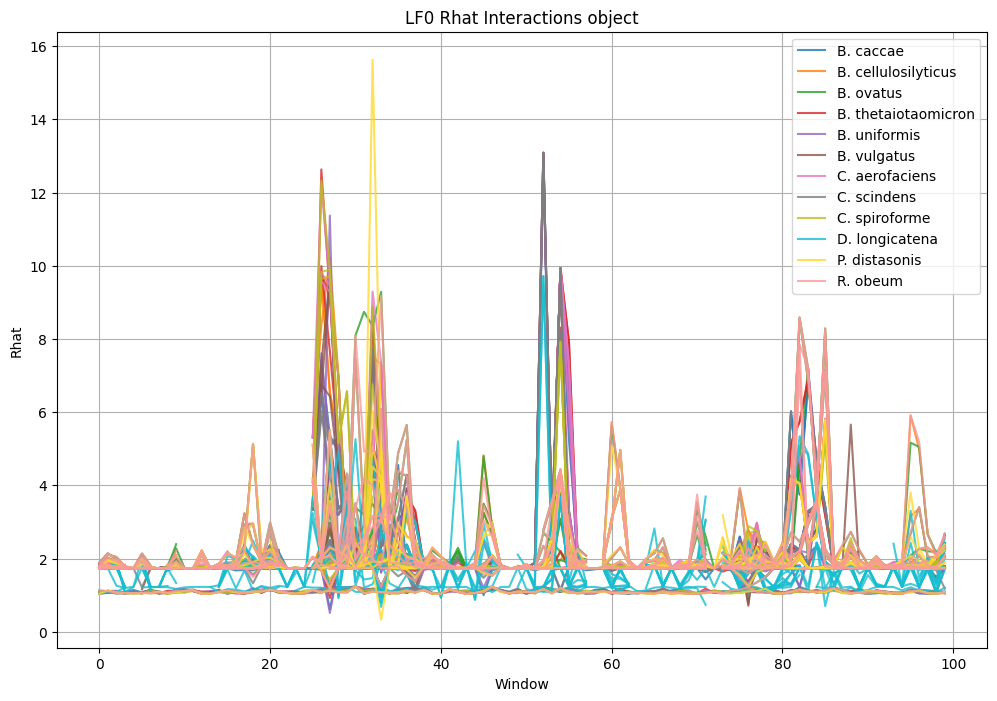

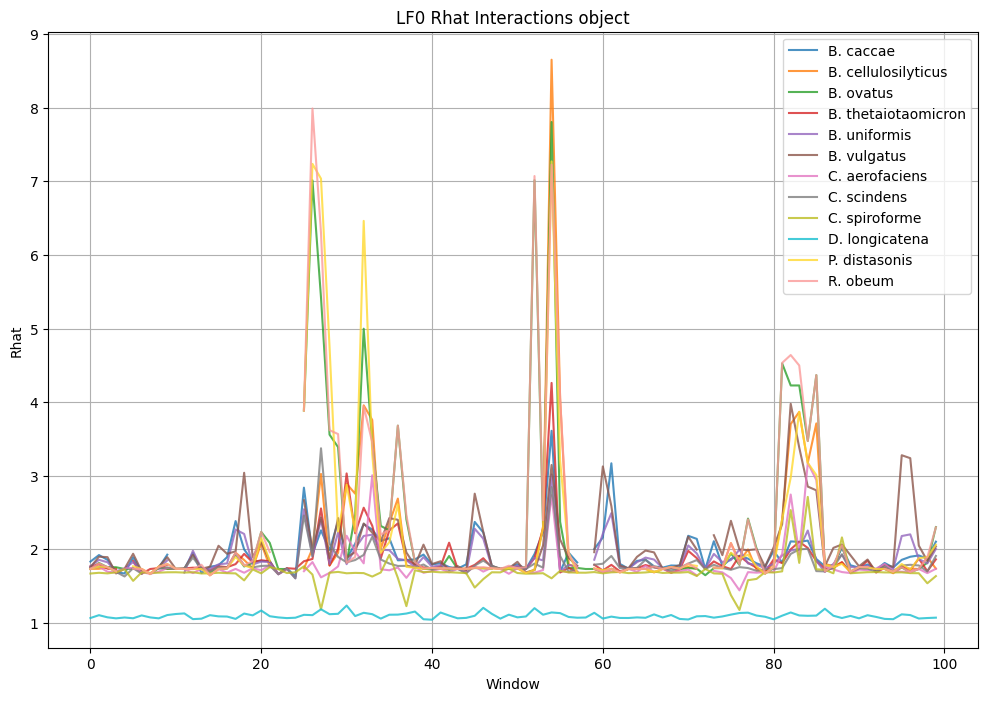

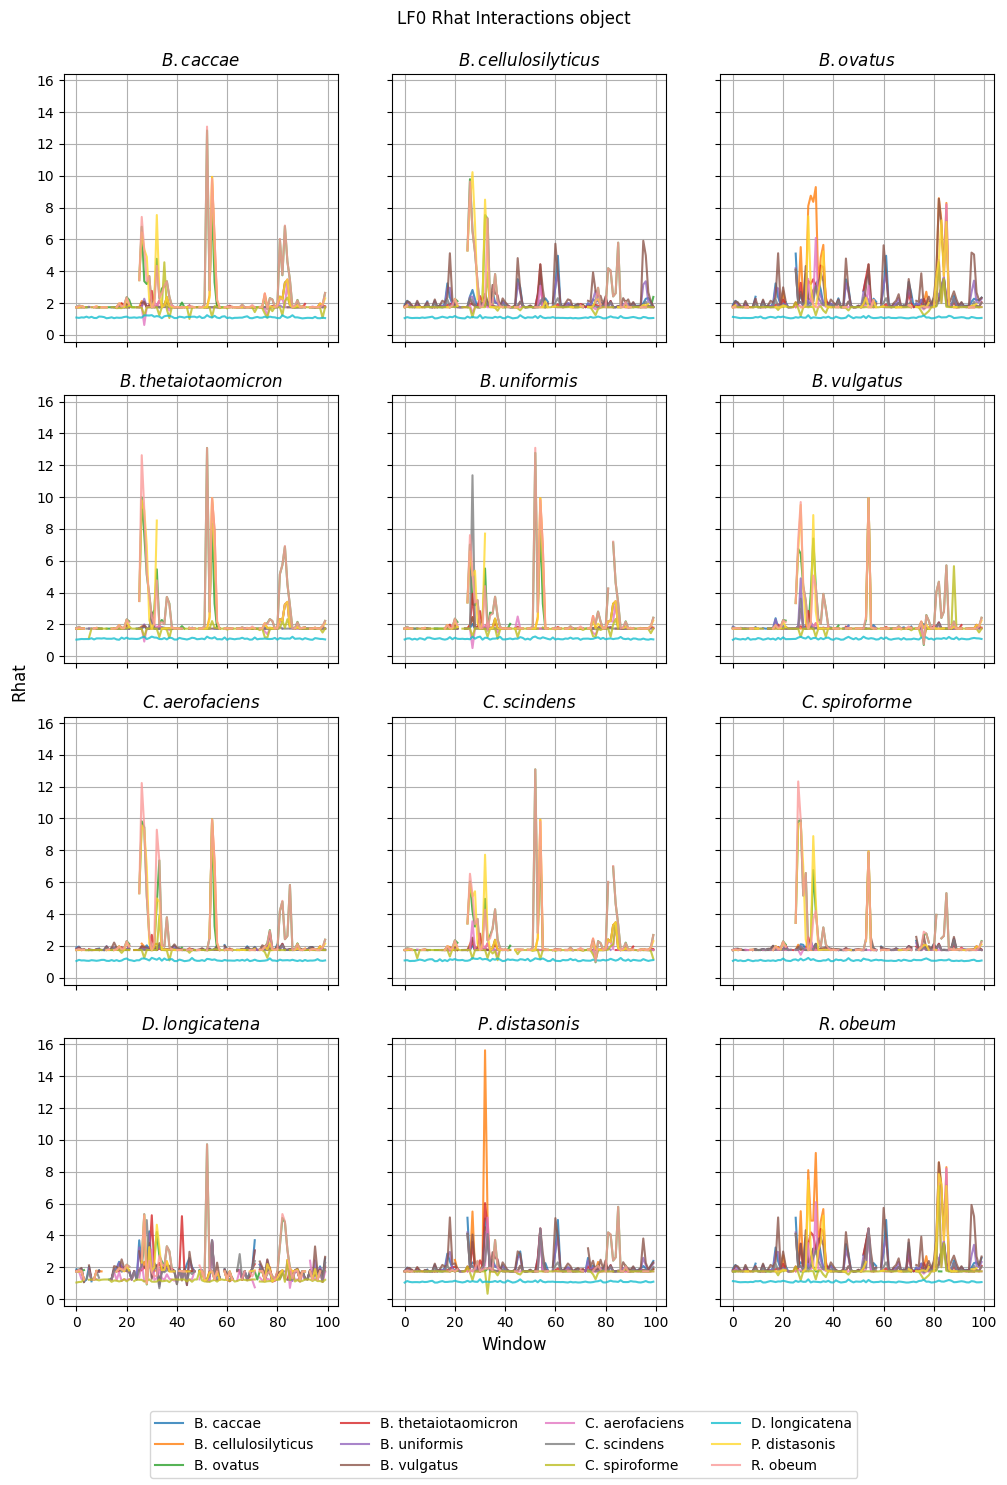

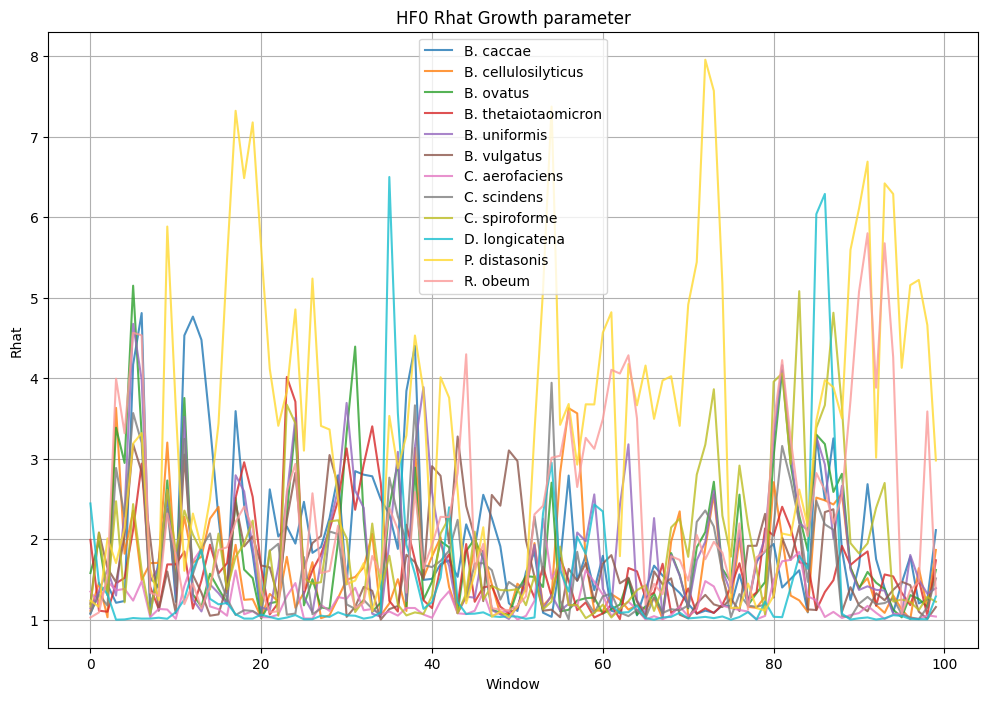

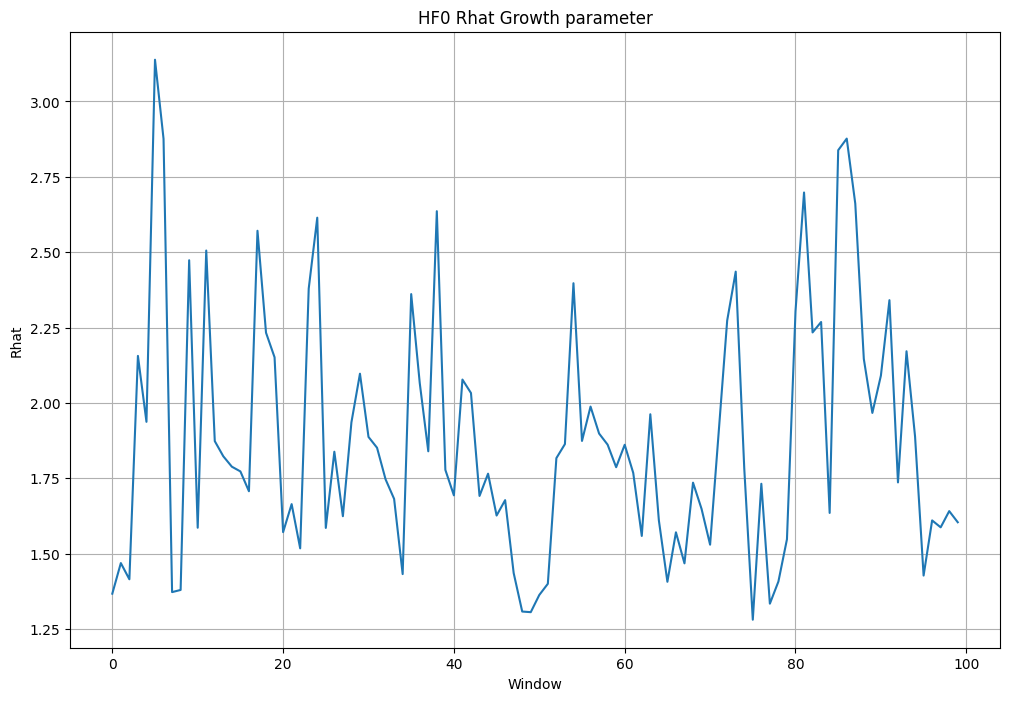

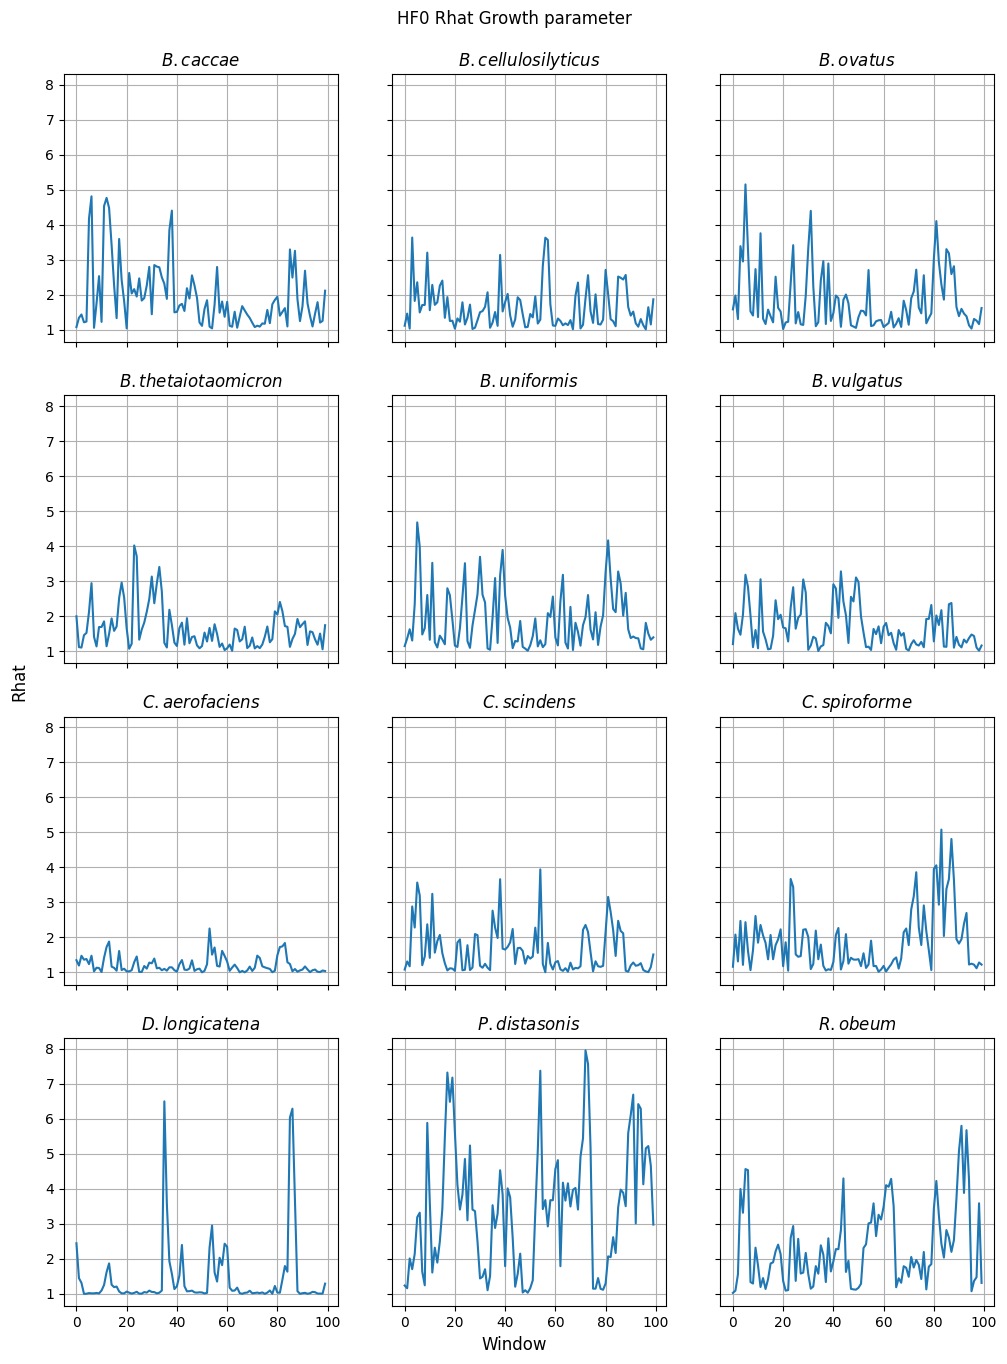

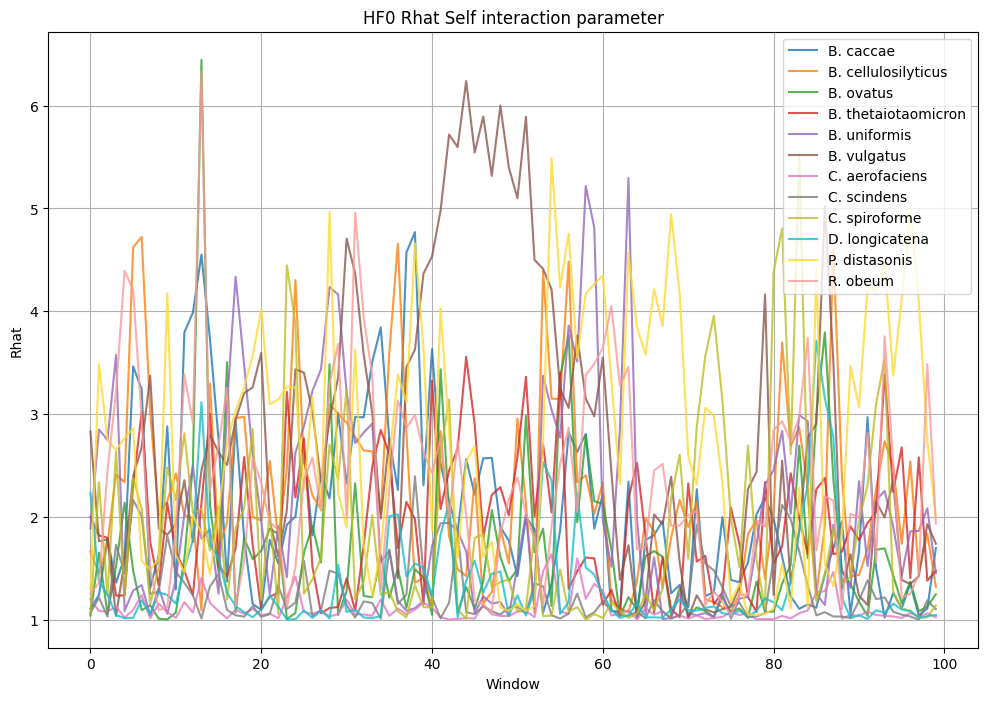

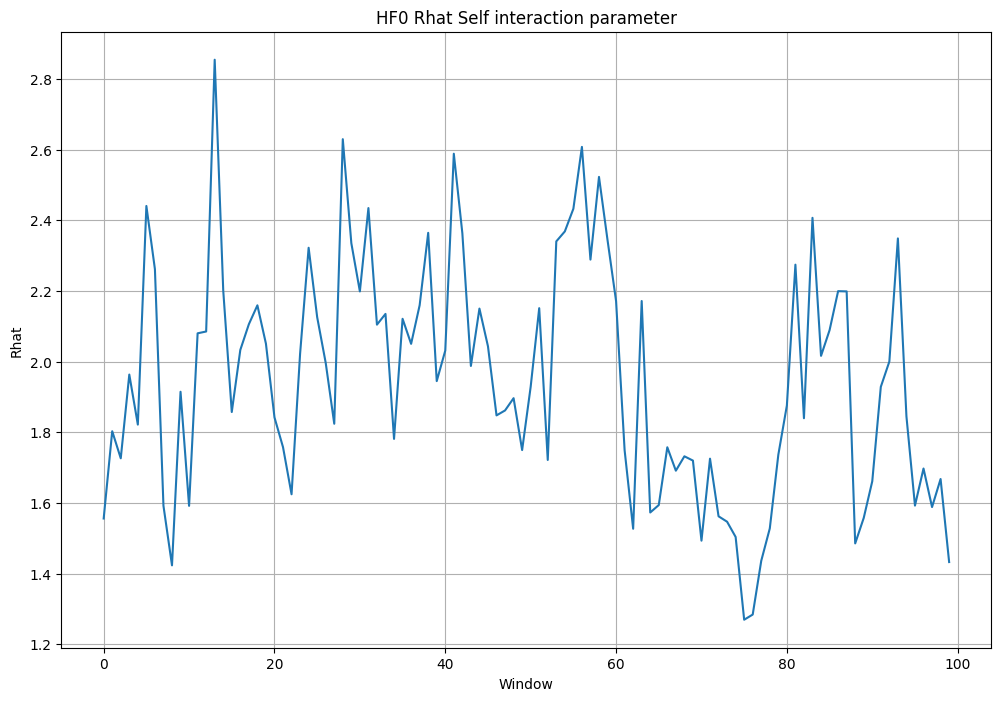

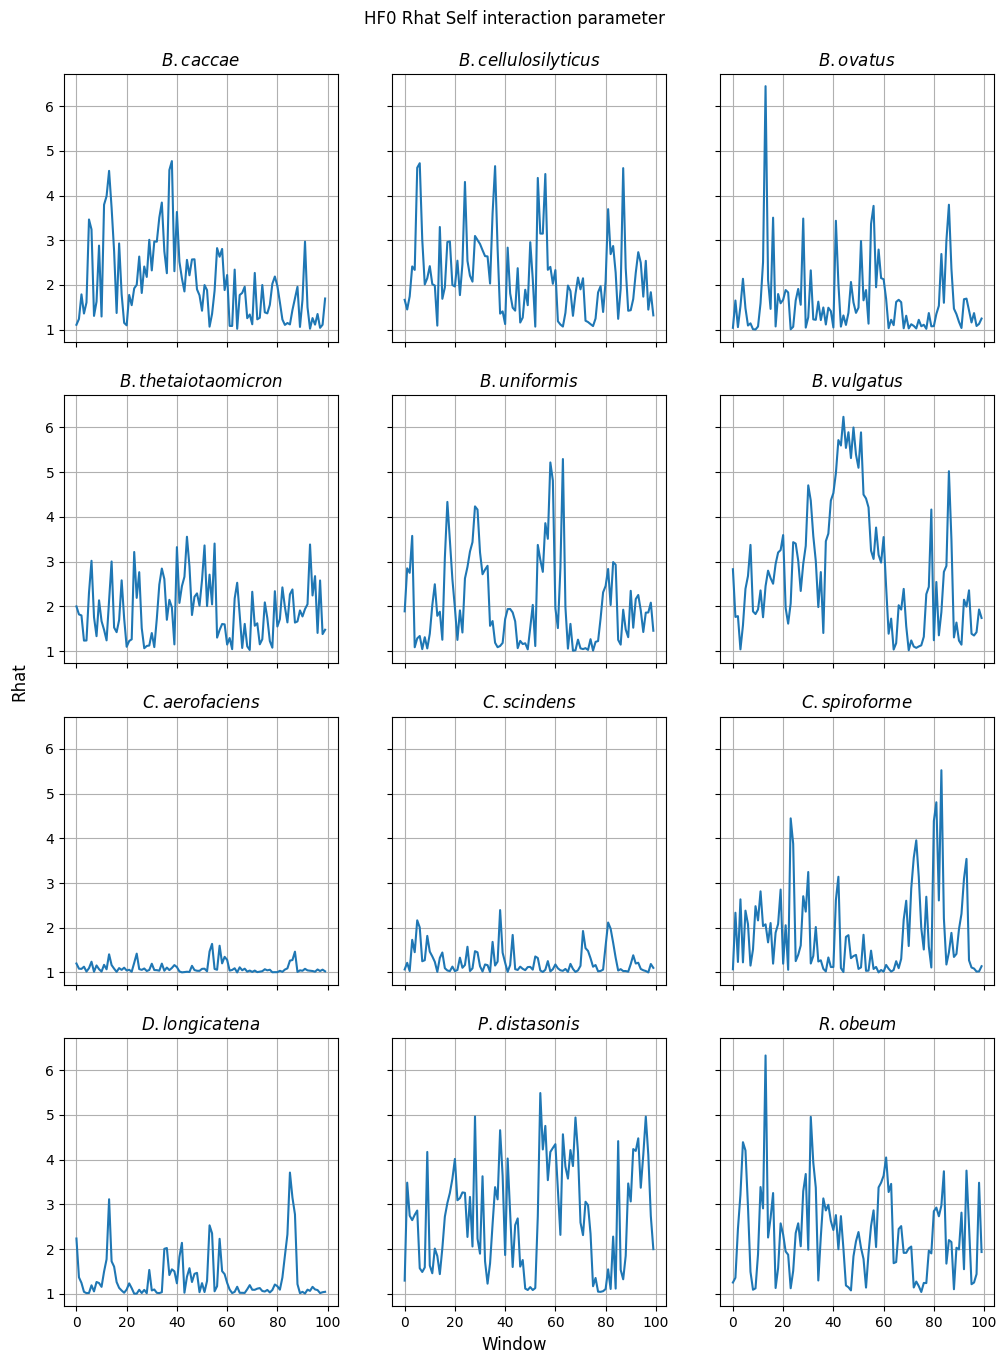

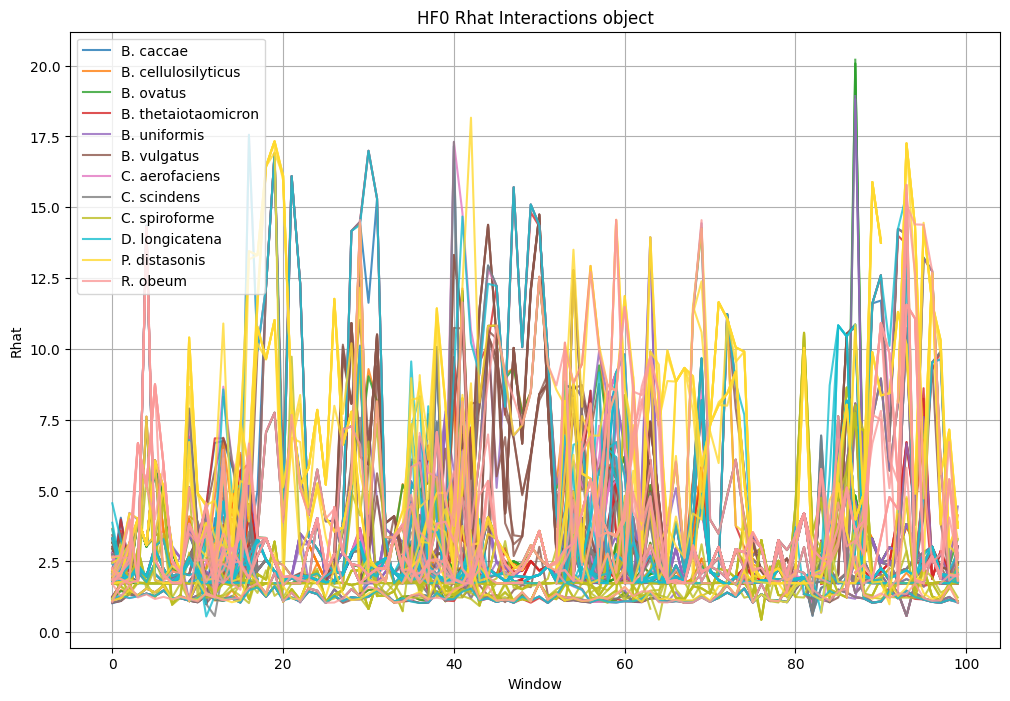

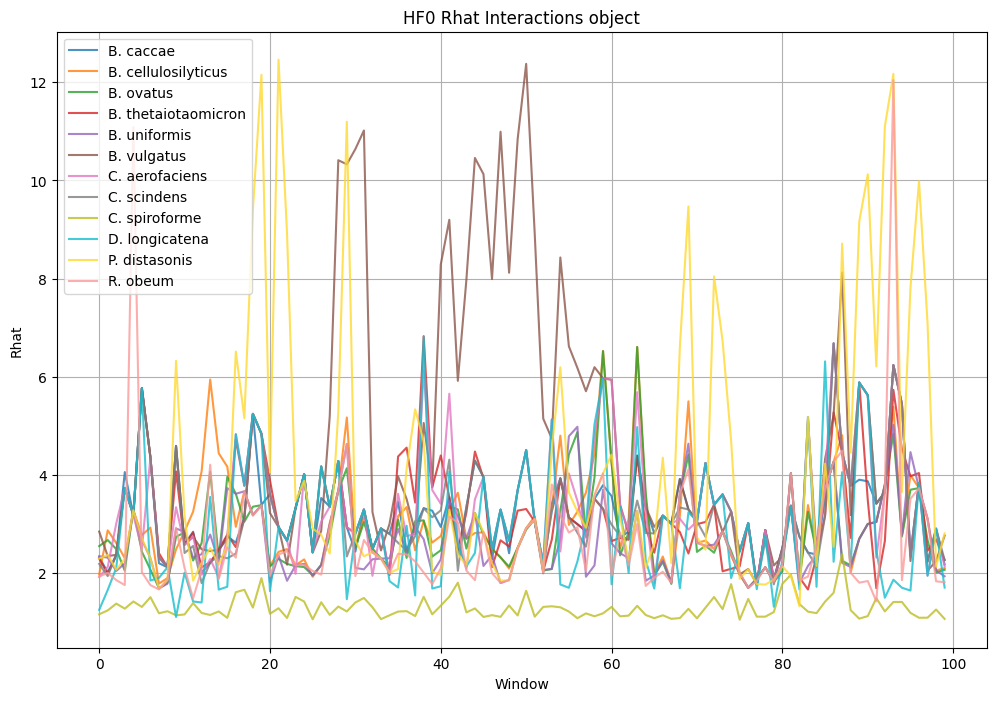

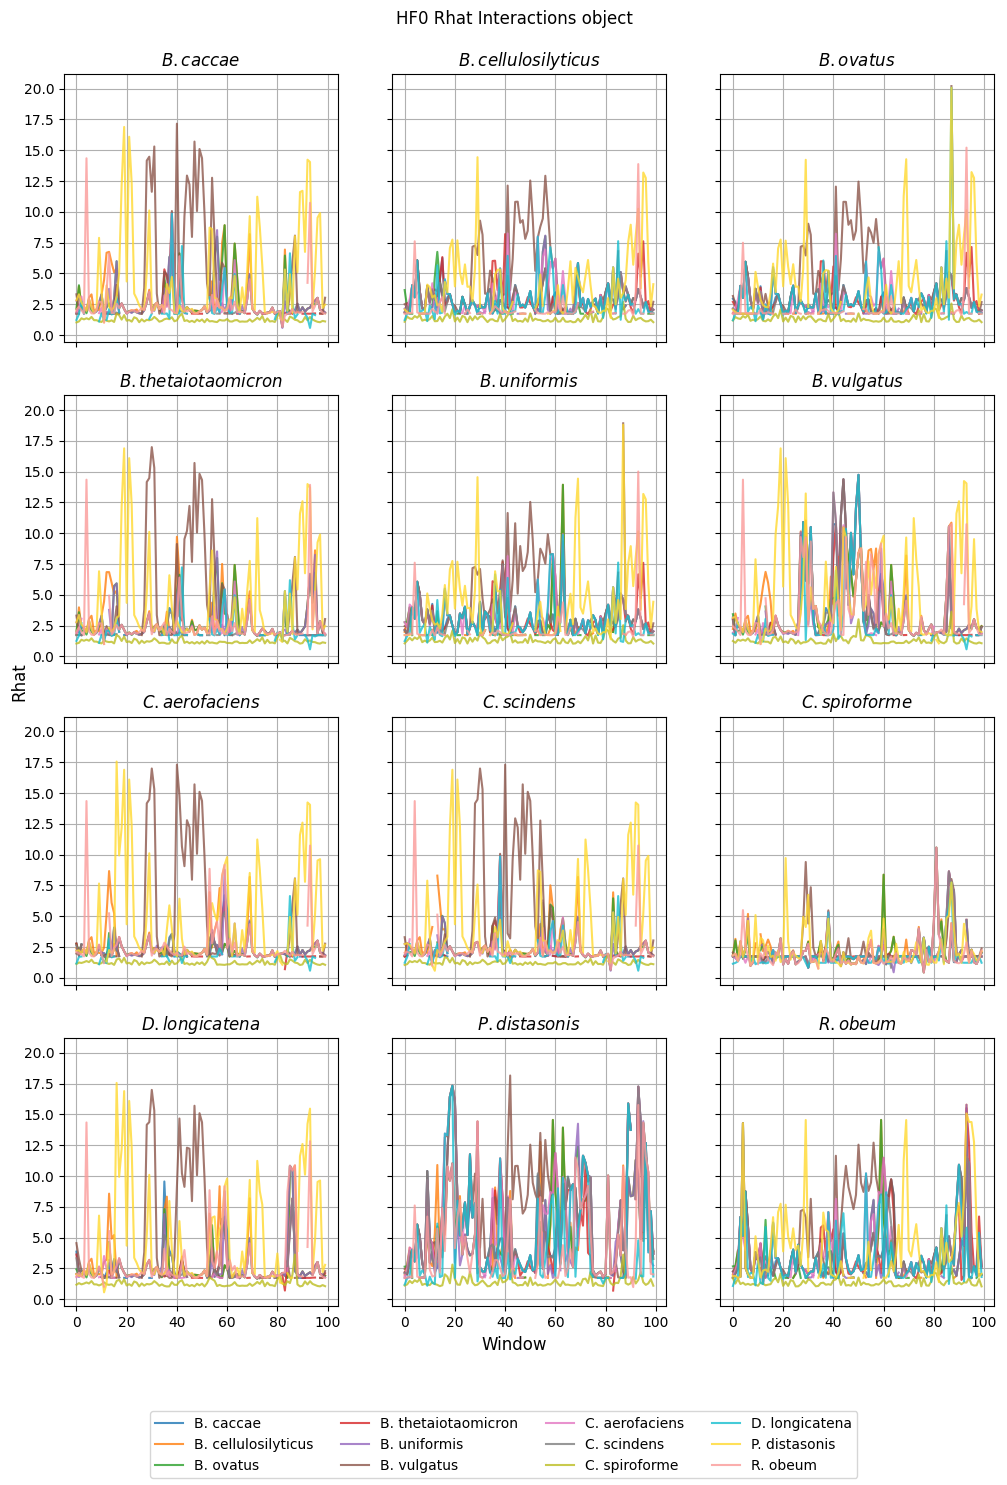

In [5]:
# Get the shrink factor for all the variables
for chains in [chains_lf0, chains_hf0]:
    for vname in [STRNAMES.GROWTH_VALUE, STRNAMES.SELF_INTERACTION_VALUE, STRNAMES.INTERACTIONS_OBJ]:
        for layout in ['overlaped', 'mean', 'subplots']:
            plot_shrink_factor(chains=chains, vname=vname, window=1000, layout=layout, save=True)